### BLOQUE DE IMPORT DE PAQUETES

#### Añadir los install

In [1]:
from keras.models import Sequential
from keras.layers import Dense
#from sklearn.datasets.samples_generator import make_blobs

from sklearn.preprocessing import RobustScaler

#from sklearn.model_selection import KFold
#from sklearn.model_selection import cross_val_score

import pickle

import datetime

import numpy as np
import pandas as pd

import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('seaborn')

C:\Users\eduardo.hernanz\AppData\Local\Continuum\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Filtramos datos: 
Pendientes <> inf

Tramos cortos

Velocidades bajas

Como usamos entrenamientos amateurs y las mediciones están hechas con relojes (que tienen cierto grado de imprecisión), filtramos para tener datos más estables y que el modelo generalice mejor

In [2]:
path = '../Entrenamientos/Procesado_Tramos.xlsx'
df = pd.read_excel(path)
df = df[df["porc"]!=np.inf]
df["puntos_en_tramo"]= df["tramo_final"]-df["tramo_inicial"]
df = df[df["puntos_en_tramo"]>9]
df = df[df["spd"]>5]

#Ya tenemos el dataframe filtrado

### Para hacer train-test tradicional

Lo mantenemos en el código porque puede ser usado para validar el modelo de forma generalizada. En primer lugar tomábamos datos de todos los entrenamientos y validábamos también con datos procedentes de cualquier entrenamiento

df2 = df[["pwr","porc","viento_aparente","spd"]]
dataset = df2.values

X = dataset[:,0:3]
Y = dataset[:,3]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

### Separación de datos en Train y Test

Hemos hecho diferentes pruebas, incluso entrenando la red con 1 sólo entrenamiento y los resultados son satisfactorios. La diferencia entre las velocidades reales y las predichas son del mismo orden que si entrenamos con mayor cantidad de puntos. El histograma de diferencias sigue una distribución normal

In [3]:
#Para entrenar con una prueba y predecir otra:

entreno = '20180527_LEVS_195_90_C_E.gpx'
prueba = '20180429_LEMG_195_90_R_C.gpx'

df_train = df[df['prueba']==entreno]
df_test = df[df['prueba']==prueba]

#Para entrenar con varias pruebas y predecir otra:

prueba = '20180429_LEMG_195_90_R_C.gpx'

df_train = df[df['prueba']!=prueba]
df_test = df[df['prueba']==prueba]

#### Comprobamos que se ha hecho correctamente el split entre Test y Train

In [4]:
df_train.prueba.unique()

array(['20180527_LEVS_195_90_C_E.gpx'], dtype=object)

In [5]:
df_test.prueba.unique()

array(['20180429_LEMG_195_90_R_C.gpx'], dtype=object)

In [6]:
X_train = df_train[["pwr","porc","viento_aparente"]] 
X_test = df_test[["pwr","porc","viento_aparente"]]
Y_train = df_train[["spd"]]
Y_test = df_test[["spd"]]

### Preprocesado: Escalado para evitar atípicos

In [7]:
scalarX = RobustScaler()

X_train_rs = scalarX.fit_transform(X_train)
X_test_rs = scalarX.transform(X_test)

### Modelado de la Red: Inicialización y Definición

In [9]:
#Probar por diferentes funciones de activacion y con regularizacion

# define and fit the final model
#model.reset_states()
model = Sequential()

model.add(Dense(4, input_dim=3, activation='relu'))
model.add(Dense(60, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae', 'mape'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4)                 16        
_________________________________________________________________
dense_2 (Dense)              (None, 60)                300       
_________________________________________________________________
dense_3 (Dense)              (None, 20)                1220      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 21        
Total params: 1,557
Trainable params: 1,557
Non-trainable params: 0
_________________________________________________________________


### Entrenamiento del Modelo

In [10]:
history = model.fit(X_train_rs, Y_train, batch_size=10, validation_data=(X_test_rs,Y_test), epochs=400, verbose=2)

Train on 121 samples, validate on 80 samples
Epoch 1/400
 - 0s - loss: 1182.5205 - mean_squared_error: 1182.5205 - mean_absolute_error: 33.7573 - mean_absolute_percentage_error: 99.6286 - val_loss: 1234.0128 - val_mean_squared_error: 1234.0128 - val_mean_absolute_error: 33.2187 - val_mean_absolute_percentage_error: 98.6025
Epoch 2/400
 - 0s - loss: 1155.6010 - mean_squared_error: 1155.6010 - mean_absolute_error: 33.3631 - mean_absolute_percentage_error: 98.4265 - val_loss: 1196.2772 - val_mean_squared_error: 1196.2772 - val_mean_absolute_error: 32.6807 - val_mean_absolute_percentage_error: 96.8417
Epoch 3/400
 - 0s - loss: 1121.4552 - mean_squared_error: 1121.4552 - mean_absolute_error: 32.8601 - mean_absolute_percentage_error: 96.9118 - val_loss: 1145.9456 - val_mean_squared_error: 1145.9456 - val_mean_absolute_error: 31.9468 - val_mean_absolute_percentage_error: 94.4447
Epoch 4/400
 - 0s - loss: 1074.0434 - mean_squared_error: 1074.0434 - mean_absolute_error: 32.1473 - mean_absolute_

Epoch 31/400
 - 0s - loss: 53.7924 - mean_squared_error: 53.7924 - mean_absolute_error: 5.8527 - mean_absolute_percentage_error: 18.6925 - val_loss: 153.4436 - val_mean_squared_error: 153.4436 - val_mean_absolute_error: 10.4526 - val_mean_absolute_percentage_error: 37.6872
Epoch 32/400
 - 0s - loss: 51.3715 - mean_squared_error: 51.3715 - mean_absolute_error: 5.7129 - mean_absolute_percentage_error: 18.2027 - val_loss: 149.6554 - val_mean_squared_error: 149.6554 - val_mean_absolute_error: 10.3273 - val_mean_absolute_percentage_error: 37.2301
Epoch 33/400
 - 0s - loss: 50.1762 - mean_squared_error: 50.1762 - mean_absolute_error: 5.5814 - mean_absolute_percentage_error: 17.9178 - val_loss: 151.1846 - val_mean_squared_error: 151.1846 - val_mean_absolute_error: 10.4341 - val_mean_absolute_percentage_error: 37.9157
Epoch 34/400
 - 0s - loss: 47.0693 - mean_squared_error: 47.0693 - mean_absolute_error: 5.3863 - mean_absolute_percentage_error: 17.3251 - val_loss: 145.0554 - val_mean_squared_e

Epoch 62/400
 - 0s - loss: 15.5424 - mean_squared_error: 15.5424 - mean_absolute_error: 3.0846 - mean_absolute_percentage_error: 9.9266 - val_loss: 71.7418 - val_mean_squared_error: 71.7418 - val_mean_absolute_error: 7.0507 - val_mean_absolute_percentage_error: 25.5785
Epoch 63/400
 - 0s - loss: 15.3067 - mean_squared_error: 15.3067 - mean_absolute_error: 3.0525 - mean_absolute_percentage_error: 9.9031 - val_loss: 69.0806 - val_mean_squared_error: 69.0806 - val_mean_absolute_error: 6.8991 - val_mean_absolute_percentage_error: 24.9049
Epoch 64/400
 - 0s - loss: 14.5056 - mean_squared_error: 14.5056 - mean_absolute_error: 3.0113 - mean_absolute_percentage_error: 9.5422 - val_loss: 65.0611 - val_mean_squared_error: 65.0611 - val_mean_absolute_error: 6.6831 - val_mean_absolute_percentage_error: 23.7242
Epoch 65/400
 - 0s - loss: 13.9157 - mean_squared_error: 13.9157 - mean_absolute_error: 2.9517 - mean_absolute_percentage_error: 9.3465 - val_loss: 64.7721 - val_mean_squared_error: 64.7721 

Epoch 93/400
 - 0s - loss: 8.8026 - mean_squared_error: 8.8026 - mean_absolute_error: 2.3104 - mean_absolute_percentage_error: 7.1088 - val_loss: 39.7961 - val_mean_squared_error: 39.7961 - val_mean_absolute_error: 4.8171 - val_mean_absolute_percentage_error: 16.7783
Epoch 94/400
 - 0s - loss: 8.7476 - mean_squared_error: 8.7476 - mean_absolute_error: 2.3103 - mean_absolute_percentage_error: 7.0944 - val_loss: 39.2658 - val_mean_squared_error: 39.2658 - val_mean_absolute_error: 4.7684 - val_mean_absolute_percentage_error: 16.5013
Epoch 95/400
 - 0s - loss: 8.6704 - mean_squared_error: 8.6704 - mean_absolute_error: 2.3020 - mean_absolute_percentage_error: 7.0738 - val_loss: 39.6617 - val_mean_squared_error: 39.6617 - val_mean_absolute_error: 4.8008 - val_mean_absolute_percentage_error: 16.7510
Epoch 96/400
 - 0s - loss: 8.7472 - mean_squared_error: 8.7472 - mean_absolute_error: 2.3385 - mean_absolute_percentage_error: 7.2602 - val_loss: 39.2343 - val_mean_squared_error: 39.2343 - val_me

Epoch 124/400
 - 0s - loss: 8.2594 - mean_squared_error: 8.2594 - mean_absolute_error: 2.2634 - mean_absolute_percentage_error: 6.8783 - val_loss: 32.0513 - val_mean_squared_error: 32.0513 - val_mean_absolute_error: 4.1856 - val_mean_absolute_percentage_error: 14.0617
Epoch 125/400
 - 0s - loss: 8.2566 - mean_squared_error: 8.2566 - mean_absolute_error: 2.2474 - mean_absolute_percentage_error: 6.7504 - val_loss: 32.1976 - val_mean_squared_error: 32.1976 - val_mean_absolute_error: 4.2120 - val_mean_absolute_percentage_error: 14.3435
Epoch 126/400
 - 0s - loss: 8.0346 - mean_squared_error: 8.0346 - mean_absolute_error: 2.2299 - mean_absolute_percentage_error: 6.8188 - val_loss: 33.0094 - val_mean_squared_error: 33.0094 - val_mean_absolute_error: 4.2754 - val_mean_absolute_percentage_error: 14.7256
Epoch 127/400
 - 0s - loss: 7.9698 - mean_squared_error: 7.9698 - mean_absolute_error: 2.2236 - mean_absolute_percentage_error: 6.8146 - val_loss: 32.5988 - val_mean_squared_error: 32.5988 - va

Epoch 155/400
 - 0s - loss: 7.8572 - mean_squared_error: 7.8572 - mean_absolute_error: 2.2218 - mean_absolute_percentage_error: 6.7674 - val_loss: 31.9217 - val_mean_squared_error: 31.9217 - val_mean_absolute_error: 4.2143 - val_mean_absolute_percentage_error: 14.3948
Epoch 156/400
 - 0s - loss: 8.0608 - mean_squared_error: 8.0608 - mean_absolute_error: 2.2537 - mean_absolute_percentage_error: 6.9238 - val_loss: 31.7921 - val_mean_squared_error: 31.7921 - val_mean_absolute_error: 4.2200 - val_mean_absolute_percentage_error: 14.5154
Epoch 157/400
 - 0s - loss: 7.8732 - mean_squared_error: 7.8732 - mean_absolute_error: 2.2012 - mean_absolute_percentage_error: 6.7141 - val_loss: 30.3780 - val_mean_squared_error: 30.3780 - val_mean_absolute_error: 4.1004 - val_mean_absolute_percentage_error: 13.9006
Epoch 158/400
 - 0s - loss: 9.3946 - mean_squared_error: 9.3946 - mean_absolute_error: 2.3920 - mean_absolute_percentage_error: 7.0436 - val_loss: 30.6230 - val_mean_squared_error: 30.6230 - va

Epoch 186/400
 - 0s - loss: 7.8587 - mean_squared_error: 7.8587 - mean_absolute_error: 2.2055 - mean_absolute_percentage_error: 6.6946 - val_loss: 30.7801 - val_mean_squared_error: 30.7801 - val_mean_absolute_error: 4.1376 - val_mean_absolute_percentage_error: 14.0072
Epoch 187/400
 - 0s - loss: 7.8153 - mean_squared_error: 7.8153 - mean_absolute_error: 2.2174 - mean_absolute_percentage_error: 6.7585 - val_loss: 31.3915 - val_mean_squared_error: 31.3915 - val_mean_absolute_error: 4.1889 - val_mean_absolute_percentage_error: 14.2539
Epoch 188/400
 - 0s - loss: 7.7263 - mean_squared_error: 7.7263 - mean_absolute_error: 2.1945 - mean_absolute_percentage_error: 6.6559 - val_loss: 30.6697 - val_mean_squared_error: 30.6697 - val_mean_absolute_error: 4.1336 - val_mean_absolute_percentage_error: 14.0126
Epoch 189/400
 - 0s - loss: 7.7339 - mean_squared_error: 7.7339 - mean_absolute_error: 2.1905 - mean_absolute_percentage_error: 6.6573 - val_loss: 31.4432 - val_mean_squared_error: 31.4432 - va

Epoch 217/400
 - 0s - loss: 7.7960 - mean_squared_error: 7.7960 - mean_absolute_error: 2.1772 - mean_absolute_percentage_error: 6.5770 - val_loss: 29.6603 - val_mean_squared_error: 29.6603 - val_mean_absolute_error: 4.0733 - val_mean_absolute_percentage_error: 13.8149
Epoch 218/400
 - 0s - loss: 8.3419 - mean_squared_error: 8.3419 - mean_absolute_error: 2.2978 - mean_absolute_percentage_error: 7.0322 - val_loss: 31.9233 - val_mean_squared_error: 31.9233 - val_mean_absolute_error: 4.2439 - val_mean_absolute_percentage_error: 14.5062
Epoch 219/400
 - 0s - loss: 7.6140 - mean_squared_error: 7.6140 - mean_absolute_error: 2.1859 - mean_absolute_percentage_error: 6.6309 - val_loss: 29.8085 - val_mean_squared_error: 29.8085 - val_mean_absolute_error: 4.0699 - val_mean_absolute_percentage_error: 13.6940
Epoch 220/400
 - 0s - loss: 7.6901 - mean_squared_error: 7.6901 - mean_absolute_error: 2.2017 - mean_absolute_percentage_error: 6.6859 - val_loss: 31.5327 - val_mean_squared_error: 31.5327 - va

Epoch 248/400
 - 0s - loss: 7.6982 - mean_squared_error: 7.6982 - mean_absolute_error: 2.1745 - mean_absolute_percentage_error: 6.5856 - val_loss: 29.1590 - val_mean_squared_error: 29.1590 - val_mean_absolute_error: 4.0586 - val_mean_absolute_percentage_error: 13.7866
Epoch 249/400
 - 0s - loss: 7.8167 - mean_squared_error: 7.8167 - mean_absolute_error: 2.1962 - mean_absolute_percentage_error: 6.6276 - val_loss: 29.1470 - val_mean_squared_error: 29.1470 - val_mean_absolute_error: 4.0675 - val_mean_absolute_percentage_error: 13.8786
Epoch 250/400
 - 0s - loss: 8.0037 - mean_squared_error: 8.0037 - mean_absolute_error: 2.2221 - mean_absolute_percentage_error: 6.8018 - val_loss: 29.9931 - val_mean_squared_error: 29.9931 - val_mean_absolute_error: 4.1304 - val_mean_absolute_percentage_error: 14.1437
Epoch 251/400
 - 0s - loss: 7.7395 - mean_squared_error: 7.7395 - mean_absolute_error: 2.1700 - mean_absolute_percentage_error: 6.5828 - val_loss: 28.9062 - val_mean_squared_error: 28.9062 - va

Epoch 279/400
 - 0s - loss: 7.9972 - mean_squared_error: 7.9972 - mean_absolute_error: 2.1984 - mean_absolute_percentage_error: 6.6073 - val_loss: 28.1380 - val_mean_squared_error: 28.1380 - val_mean_absolute_error: 3.9556 - val_mean_absolute_percentage_error: 13.2832
Epoch 280/400
 - 0s - loss: 8.6147 - mean_squared_error: 8.6147 - mean_absolute_error: 2.3401 - mean_absolute_percentage_error: 7.1328 - val_loss: 32.7168 - val_mean_squared_error: 32.7168 - val_mean_absolute_error: 4.2875 - val_mean_absolute_percentage_error: 14.4586
Epoch 281/400
 - 0s - loss: 7.7860 - mean_squared_error: 7.7860 - mean_absolute_error: 2.1844 - mean_absolute_percentage_error: 6.6063 - val_loss: 27.9178 - val_mean_squared_error: 27.9178 - val_mean_absolute_error: 3.8982 - val_mean_absolute_percentage_error: 12.8655
Epoch 282/400
 - 0s - loss: 8.5416 - mean_squared_error: 8.5416 - mean_absolute_error: 2.2626 - mean_absolute_percentage_error: 6.6646 - val_loss: 28.2195 - val_mean_squared_error: 28.2195 - va

Epoch 310/400
 - 0s - loss: 7.6691 - mean_squared_error: 7.6691 - mean_absolute_error: 2.1492 - mean_absolute_percentage_error: 6.4416 - val_loss: 28.6884 - val_mean_squared_error: 28.6884 - val_mean_absolute_error: 4.0045 - val_mean_absolute_percentage_error: 13.4315
Epoch 311/400
 - 0s - loss: 7.6993 - mean_squared_error: 7.6993 - mean_absolute_error: 2.1749 - mean_absolute_percentage_error: 6.6563 - val_loss: 30.0612 - val_mean_squared_error: 30.0612 - val_mean_absolute_error: 4.1562 - val_mean_absolute_percentage_error: 14.2157
Epoch 312/400
 - 0s - loss: 7.6206 - mean_squared_error: 7.6206 - mean_absolute_error: 2.1670 - mean_absolute_percentage_error: 6.5929 - val_loss: 28.0171 - val_mean_squared_error: 28.0171 - val_mean_absolute_error: 3.9707 - val_mean_absolute_percentage_error: 13.4224
Epoch 313/400
 - 0s - loss: 7.6087 - mean_squared_error: 7.6087 - mean_absolute_error: 2.1530 - mean_absolute_percentage_error: 6.5286 - val_loss: 28.7384 - val_mean_squared_error: 28.7384 - va

Epoch 341/400
 - 0s - loss: 7.6946 - mean_squared_error: 7.6946 - mean_absolute_error: 2.1714 - mean_absolute_percentage_error: 6.5062 - val_loss: 30.0713 - val_mean_squared_error: 30.0713 - val_mean_absolute_error: 4.1439 - val_mean_absolute_percentage_error: 14.0832
Epoch 342/400
 - 0s - loss: 7.5309 - mean_squared_error: 7.5309 - mean_absolute_error: 2.1619 - mean_absolute_percentage_error: 6.5955 - val_loss: 29.0901 - val_mean_squared_error: 29.0901 - val_mean_absolute_error: 4.0721 - val_mean_absolute_percentage_error: 13.7664
Epoch 343/400
 - 0s - loss: 7.4889 - mean_squared_error: 7.4889 - mean_absolute_error: 2.1443 - mean_absolute_percentage_error: 6.5068 - val_loss: 29.0680 - val_mean_squared_error: 29.0680 - val_mean_absolute_error: 4.0730 - val_mean_absolute_percentage_error: 13.7917
Epoch 344/400
 - 0s - loss: 7.6737 - mean_squared_error: 7.6737 - mean_absolute_error: 2.1669 - mean_absolute_percentage_error: 6.6057 - val_loss: 28.8899 - val_mean_squared_error: 28.8899 - va

Epoch 372/400
 - 0s - loss: 7.4724 - mean_squared_error: 7.4724 - mean_absolute_error: 2.1586 - mean_absolute_percentage_error: 6.5749 - val_loss: 30.2153 - val_mean_squared_error: 30.2153 - val_mean_absolute_error: 4.1519 - val_mean_absolute_percentage_error: 14.0786
Epoch 373/400
 - 0s - loss: 7.4877 - mean_squared_error: 7.4877 - mean_absolute_error: 2.1578 - mean_absolute_percentage_error: 6.5726 - val_loss: 29.4222 - val_mean_squared_error: 29.4222 - val_mean_absolute_error: 4.0905 - val_mean_absolute_percentage_error: 13.7959
Epoch 374/400
 - 0s - loss: 7.6918 - mean_squared_error: 7.6918 - mean_absolute_error: 2.1574 - mean_absolute_percentage_error: 6.4622 - val_loss: 29.4457 - val_mean_squared_error: 29.4457 - val_mean_absolute_error: 4.0750 - val_mean_absolute_percentage_error: 13.6943
Epoch 375/400
 - 0s - loss: 7.4370 - mean_squared_error: 7.4370 - mean_absolute_error: 2.1460 - mean_absolute_percentage_error: 6.5220 - val_loss: 29.2881 - val_mean_squared_error: 29.2881 - va

In [11]:
# Listado de métricas almacenadas durante el entrenamiento
print(history.history.keys())

dict_keys(['val_loss', 'val_mean_squared_error', 'val_mean_absolute_error', 'val_mean_absolute_percentage_error', 'loss', 'mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error'])


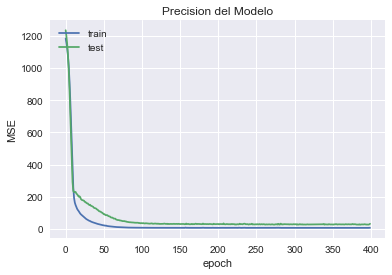

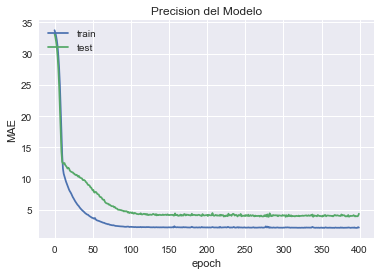

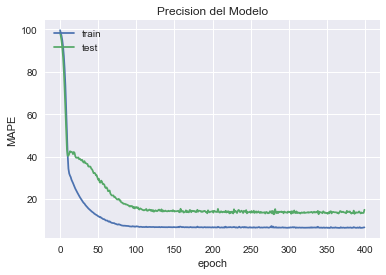

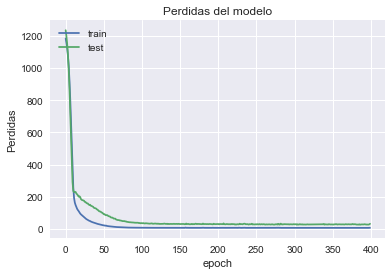

In [12]:
# Resumen de 'mean_squared_error'
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Precision del Modelo')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Resumen de 'mean_absolute_error'
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Precision del Modelo')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Resumen de 'mean_absolute_percentage_error'
plt.plot(history.history['mean_absolute_percentage_error'])
plt.plot(history.history['val_mean_absolute_percentage_error'])
plt.title('Precision del Modelo')
plt.ylabel('MAPE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Resumen de la funcion de perdida definida
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perdidas del modelo')
plt.ylabel('Perdidas')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Predicción

In [ ]:
# make a prediction
Y_pred = model.predict(X_test_rs)

# show the inputs and predicted outputs
for i in range(len(X_test_rs)):
        print("X=%s, Predicted=%s" % (X_test_rs[i], Y_pred[i]))


In [ ]:
#Creamos el dataframe de validación
test_val = pd.DataFrame(X_test)
test_val.columns = (["pwr","porc","viento_aparente"])
test_val["spd"] = Y_test
test_val["Y_pred"] = Y_pred
test_val["diff"] = test_val["spd"]-test_val["Y_pred"]
test_val.head()

In [ ]:
#Ploteamos las diferencias entre las velocidades reales y las predichas por el modelo
plt.hist(test_val['diff'])

In [ ]:
#Mostramos los valores significativos de las predicciones y la diferencia con los reales

print("Predicciones:")
print(test_val["Y_pred"].mean())
print(test_val["Y_pred"].max())
print(test_val["Y_pred"].min())

print("Diferencias:")
print(test_val["diff"].mean())
print(test_val["diff"].max())
print(test_val["diff"].min())

#### Comprobaciones finales del resultado

In [ ]:
test_val['dist'] = df_test['dist']
test_val['time_seg'] = df_test['time_seg']
test_val['time_seg_pred'] = test_val['dist']/(test_val['Y_pred']/3.6)

In [ ]:
tiempo_real = test_val['time_seg'].sum()
tiempo_pred = test_val['time_seg_pred'].sum()
print('Tiempo Real: %s' %str(datetime.timedelta(seconds=int(tiempo_real))))
print('Tiempo Predicho: %s' %str(datetime.timedelta(seconds=tiempo_pred)))

#### Mostramos los datos con mayor diferencia para analizar

In [ ]:
test_val[(test_val["diff"]>8) | (test_val["diff"]<-10)]

### Exportamos el Modelo para ser usado en el Simulador

In [ ]:
pickle.dump(scalarX, open("Scaler.model", 'wb'))


model.save("TF_Tramos_2.model")
#Para cargar el modelo
#https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model